In [24]:
import copy
import datetime
import pickle
import itertools
import time

import simpy
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

import opentnsim.core

In [15]:
with open('experiment3-graph.pickle', 'rb') as f:
    graph = pickle.load(f)

In [16]:
route_alternatives = [
    {
        "name": "direct",
        "waypoints": ['A', 'D', 'H']
    },
    {
        "name": "redirect",
        "waypoints": ['A', 'H', 'D']
    },
]


for alternative in route_alternatives:
    route = []    
    waypoints = alternative["waypoints"]
    for a, b in zip(waypoints[:-1], waypoints[1:]):
        path = nx.shortest_path(graph, a, b)
        route.extend(path)
        
    route = [
        k 
        for (k, g)
        in itertools.groupby(route)
    ]


    alternative["route"] = route
route_alternatives

[{'name': 'direct',
  'waypoints': ['A', 'D', 'H'],
  'route': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']},
 {'name': 'redirect',
  'waypoints': ['A', 'H', 'D'],
  'route': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'G', 'F', 'E', 'D']}]

In [17]:
engine_orders = [0.5, 0.6, 0.7, 0.8, 0.9]

alternatives = []
for engine_order in engine_orders:
    for route_alternative in route_alternatives:
        alternative = copy.deepcopy(route_alternative)
        alternative['engine_order'] = engine_order
        alternatives.append(alternative)
        
alternatives_df = pd.DataFrame(alternatives)
# not the direct route
alternatives_df['green_routing'] = alternatives_df['name'] == 'redirect'
# not the maximum power
alternatives_df['green_steaming'] = alternatives_df['engine_order'] < engine_orders[-1]
alternatives_df

,name,waypoints,route,engine_order,green_routing,green_steaming
0,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.5,False,True
1,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.5,True,True
2,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.6,False,True
3,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.6,True,True
4,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.7,False,True
5,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.7,True,True
6,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.8,False,True
7,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.8,True,True
8,direct,"[A, D, H]","[A, B, C, D, E, F, G, H]",0.9,False,False
9,redirect,"[A, H, D]","[A, B, C, D, E, F, G, H, G, F, E, D]",0.9,True,False


# Load the network from a file
We have drawn a notebook, similar to the Port of Rotterdam. The goal is to have a ship "Blue" moving from A to B, wait at B, then the ship will move from B to C. 

When ship "Green" starts, it should notice that B is occupied. Ship "Green" will have to decide whether to sail slower or to adapt it's route by going from A to C to B, to avoid waiting for ship "Blue"

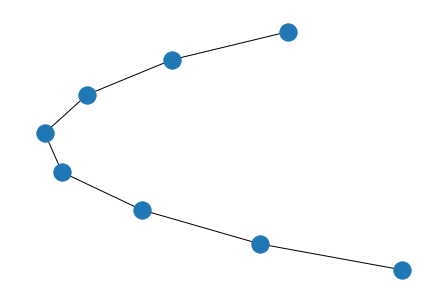

In [18]:
nx.draw(graph)

In [29]:
def run_simulation(geometry, route, graph, engine_order=0.8):
    Vessel = type(
        'Vessel', 
        (
            opentnsim.core.Identifiable, 
            opentnsim.core.Movable, 
            opentnsim.core.HasResource, 
            opentnsim.core.Routeable, 
            opentnsim.core.HasContainer
        ), 
        {}
    )

    data_vessel = {
        "env": None,
        "name": "NausBot",
        "route": None,
        "geometry": geometry,
        "capacity": 1_000,
        "v": engine_order
    } 
    vessel = Vessel(**data_vessel)

    # start simpy environment (specify the start time and add the graph to the environment)
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.FG = graph

    # add environment to the vessel, and specify the vessels route and current location (beginning of the path)
    vessel.env = env
    vessel.route = route

    # specify the process that needs to be executed
    env.process(vessel.move())

    # start the simulation
    env.run()

    #Determine trip time
    start_time = simulation_start.timestamp()

    end = vessel.log["Timestamp"][-1]

    end_time = end.timestamp()


    return end_time-start_time, end




In [30]:
row = alternatives_df.iloc[0]

In [36]:
result = alternatives_df.copy()
for idx, row in alternatives_df.iterrows():
    current_node = row['route'][0]
    geometry = graph.nodes[current_node]['geometry']
    route = row['route']
    graph = graph
    engine_order = row['engine_order']
    duration, eta = run_simulation(geometry=geometry, route=route, graph=graph, engine_order=engine_order)
    result.at[idx, 'duration'] = duration

In [37]:
# best option from duration perspective
result.loc[alternatives_df['duration'].argmin()]

name                                direct
waypoints                        [A, D, H]
route             [A, B, C, D, E, F, G, H]
engine_order                           0.9
green_routing                        False
green_steaming                       False
duration                         81.064119
Name: 8, dtype: object